In [ ]:
#Jeremy Brouillet

#### Introduction  

Semantic segmentation, namely identifying different classes in an image, is an important problem in computer vision. Important applications include identifying cancerous and non-cancerous cells, distinguishing between pedestrians, cars, and roads. One can turn images into actionable decisions, such as performing surgery or steering a car into an open lane. The goal of this notebook is to demonstrate image segmentation on a standard dataset.

One way to solve this task is deep learning. By applying a neural net to pixel-level information, I encoded the features that are significant in identifying objects. A decoder is fed these features along with the image data and is able to reconstruct the image with classes rather than RGB pixel values.

There has been a significant amount of work into this active application and area of research. A number of architectures have been used, such as U-Net [1], Segnet[2], and Fully Convolutional Networks (FCN) [3]. These networks use multiple layers of convolution, ReLu, and pooling layers to encode the images, reducing the width and height while increasing the number of feature channels. These are then upsampled and combined with passthrough networks. I used a modified U-Net structure.

<img src="./example3.png" width=700 height=200 />

#### Data Set:
There are a number of datasets associated with image segmentation. I used the Cityscapes [4] dataset. Cityscapes is a number of well-annotated photos taken in a variety of European cities.

#### Model:
I use VGGnet [5] trained on ImageNet [6] to build our initial encoder. The network consists of a series of convolution and pooling layers. By using an established model trained on a large dataset, O will have more rapid convergence, as VGGnet will have already identified the proper set of features relevant to classification and will feed them to the decoder network. 

For the decoder network, I use a modified U-Net architecture. It consists of a series of convolutions, upsampling, batch renormalization layers, and passthrough layers. Upsampling layers are needed to increase the pixel count back to the original resolution of the image. Batch renormalization ensures that the gradients through the network do not vanish. By using passthrough from the encoder VGGnet, we can use more of the original positional information. By using successive layers, we can decoder and reconstruct the image with proper class labels.

#### Outline:  
I load the libraries and data, examine basic images, load the pre-trained encoder layer, build the decoder layer on top of it, train the full neural network, and discuss the results. Lastly, I provide addition steps for future work.

#### Citations:
1. Ronneberger, O., Fischer, P., Brox, T.: U-Net: Convolutional Networks for Biomedical Image Segmentation (2015), arXiv:1505.04597 [cs.CV]
2. Badrinarayanan, V., Kendall, A., Cipolla, R.: SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation (2016), arXiv:1511.00561 [cs.CV]
3. Shelhamer, E., Long, J., Darrell, T.: Fully Convolutional Networks for Semantic Segmentation (2016), arXiv:1605.06211 [cs.CV]
4. M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, “The Cityscapes Dataset for Semantic Urban Scene Understanding,” in Proc. of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016.
5. Simonyan, K., Zisserman, A.: Very Deep Convolutional Networks for Large-Scale Image Recognition (2015), arXiv:1409.1556 [cs.CV]
6. Russakovsky O.*, Deng J.*, Su H., Krause J, Satheesh S., Ma S.,  Huang Z., Karpathy A., Khosla A., Bernstein M., Berg A. C., Fei-Fei L. "ImageNet Large Scale Visual Recognition Challenge," in IJCV, 2015.


In [2]:
#Load tensforflow, the deep learning framework I will be using. TensorFlow 2
import tensorflow as tf
#Limits the memory consumption of the GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True) 
%load_ext tensorboard

In [3]:
#Import other useful libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from skimage.transform import rescale, resize
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D
import gc
import datetime

In [4]:
#Load in image dataset
#Note that the license agreement for Cityscapes instructs me to not to post the data publically.
#If you are interested, you can download the dataset at https://www.cityscapes-dataset.com/downloads/.
def get_images_x(pathX):
    """Returns an array of all images on a given path."""
    names=os.listdir(pathX)
    names.sort()
    images = [imageio.imread(os.path.join(pathX,name)) for name in names]
    return np.array(images)

def get_images_y(pathY):
    """Returns an array of all labeled images on a given path."""
    names=os.listdir(pathY)
    names.sort()
    images=[]
    for name in names:
        if name[-12:]=='labelIds.png': #Choose the proper type of train_y image.
            img=imageio.imread(os.path.join(pathY,name))
            images.append(img)
    return np.array(images)

#strasbourg: 365 images. 
#Owing to limited compute power, we train on a reduced subset of images.
pathX='./input/leftImg8bit/train/strasbourg/'
pathY='./input/gtFine/train/strasbourg/'
train_x = get_images_x(pathX)
train_y = get_images_y(pathY)

#ulm: 95 images
pathXtest='./input/leftImg8bit/train/ulm/'
pathYtest='./input/gtFine/train/ulm/'
test_x = get_images_x(pathXtest)
test_y = get_images_y(pathYtest)

#Resize Image. Note that this stretches the image as the aspect ratio changes.
#Image needs to be resized to match the pre-training of VGGnet on ImageNet
IMG_WIDTH=224
IMG_HEIGHT=224
train_x_resized = tf.image.resize(train_x, [IMG_WIDTH, IMG_HEIGHT], method='nearest')
train_y_resized = tf.image.resize(np.reshape(train_y,(*np.shape(train_y),1)), [IMG_WIDTH, IMG_HEIGHT], method='nearest')
test_x_resized = tf.image.resize(test_x, [IMG_WIDTH, IMG_HEIGHT], method='nearest')
test_y_resized = tf.image.resize(np.reshape(test_y,(*np.shape(test_y),1)), [IMG_WIDTH, IMG_HEIGHT], method='nearest')

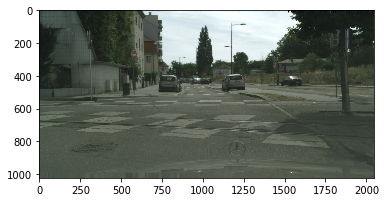

In [24]:
#Typical images from the dataset: 
plt.imshow(train_x[2], interpolation='nearest')

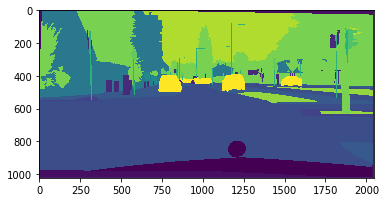

In [84]:
#Labeling of the image: 
plt.imshow(train_y[2], interpolation='nearest')

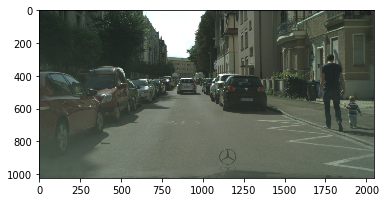

In [17]:
#Test images: Similar to training set
plt.imshow(test_x[2], interpolation='nearest')

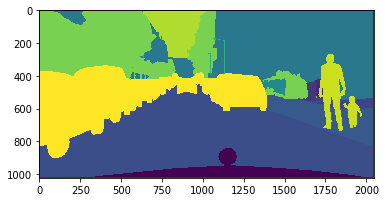

In [18]:
#Test image, class label truth.
#A more sophisticated approach would be to use a validation training set
#It would give a train/validation/test split
plt.imshow(test_y[2], interpolation='nearest')

In [16]:
listUniques = np.unique(np.array(train_y_resized))
print("Number of classes: " + str(len(listUniques)))

Number of classes: 33


In [4]:
#CPU is used train as the model does not easily fit into my 2GB GPU memory.
with tf.device('/CPU:0'): 
    model_vgg = tf.keras.applications.VGG16(weights='imagenet',include_top=False)
    model_vgg.trainable = False
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

tf.summary() shows our model. However, the output shapes not as informative as they could be. The first column, None, refers to the number of rows we have in our training set. The second and third None correspond to rows and columns, which is compressed by the various pooling layers. As I need to use passthrough layers in order to bring information forward to higher levels in the network, it is necessary to know the actual shape when used on the 224x224 training set. Hence, the use of a helper function below to identify the layer shapes.

In [20]:
def findLayerShape(model,layer_name):
    index = None
    model_name = model_other
    for idx, layer in enumerate(model_name.layers):
        if layer.name == (layer_name):
            index = idx
            print(index)
           # break
    model_moving = tf.keras.models.Model(model_name.input,model_name.layers[index].output)
    #model_name.summary()
    return np.shape(model_moving.predict(train_x_resized[0:5]))
ln = []
for idx,layer in enumerate(model_other.layers):
    layer_name = model_other.layers[idx].name
    layerShape = findLayerShape(model_other,layer_name)
    ln.append((layer_name,layerShape))

In [76]:
for layerName,layerShape in ln:
    print(layerName +" : " + str(layerShape))

input_1 : (5, 224, 224, 3)
block1_conv1 : (5, 224, 224, 64)
block1_conv2 : (5, 224, 224, 64)
block1_pool : (5, 112, 112, 64)
block2_conv1 : (5, 112, 112, 128)
block2_conv2 : (5, 112, 112, 128)
block2_pool : (5, 56, 56, 128)
block3_conv1 : (5, 56, 56, 256)
block3_conv2 : (5, 56, 56, 256)
block3_conv3 : (5, 56, 56, 256)
block3_pool : (5, 28, 28, 256)
block4_conv1 : (5, 28, 28, 512)
block4_conv2 : (5, 28, 28, 512)
block4_conv3 : (5, 28, 28, 512)
block4_pool : (5, 14, 14, 512)
block5_conv1 : (5, 14, 14, 512)
block5_conv2 : (5, 14, 14, 512)
block5_conv3 : (5, 14, 14, 512)
block5_pool : (5, 7, 7, 512)
conv2d : (5, 7, 7, 256)
up_sampling2d : (5, 14, 14, 256)
batch_normalization : (5, 14, 14, 256)
conv2d_1 : (5, 14, 14, 128)
up_sampling2d_1 : (5, 28, 28, 128)
batch_normalization_1 : (5, 28, 28, 128)
conv2d_2 : (5, 28, 28, 64)
up_sampling2d_2 : (5, 56, 56, 64)
batch_normalization_2 : (5, 56, 56, 64)
conv2d_3 : (5, 56, 56, 32)
up_sampling2d_3 : (5, 112, 112, 32)
batch_normalization_3 : (5, 112, 

I choose SparseCategoricalCrossentropy loss as we have a large number of classes. In order for this to work properly, the final layer is a softmax layer with a number of filters of 34, corresponding to the number of classes. This layer will give the probibility that each pixel corresponds to each class, with a vector of length 34 that sums to 1.

In [ ]:
#Build the full neural net
with tf.device('/CPU:0'):
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(model_vgg.output)
    up6 = tf.keras.layers.UpSampling2D(size = (2,2))(conv6)
    batch1 = tf.keras.layers.BatchNormalization()(up6)
    merge1 = tf.keras.layers.concatenate([model_vgg.get_layer('block4_pool').output,batch1], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = tf.keras.layers.UpSampling2D(size = (2,2))(conv7)
    batch2 = tf.keras.layers.BatchNormalization()(up7)
    merge2 = tf.keras.layers.concatenate([model_vgg.get_layer('block3_pool').output,batch2], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
    up8 = tf.keras.layers.UpSampling2D(size = (2,2))(conv8)
    batch3 = tf.keras.layers.BatchNormalization()(up8)
    merge3 = tf.keras.layers.concatenate([model_vgg.get_layer('block2_pool').output,batch3], axis = 3)
    conv9 = tf.keras.layers.Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    up9 = tf.keras.layers.UpSampling2D(size = (2,2))(conv9)
    batch4 = tf.keras.layers.BatchNormalization()(up9)
    merge4 = tf.keras.layers.concatenate([model_vgg.get_layer('block1_pool').output,batch4], axis = 3)
    conv10 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
    up10 = tf.keras.layers.UpSampling2D(size = (2,2))(conv10)
    batch5 = tf.keras.layers.BatchNormalization()(up10)
    conv11 = tf.keras.layers.Conv2D(34, 1, activation = 'softmax')(batch5)
    model_other = tf.keras.models.Model(model_vgg.input,conv11)
    model_other.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [46]:
#Summary of the full model
model_other.summary()

Model: "model_241"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________

Begin training. Training was run over a number of training periods. With successive training steps, the loss decreases and the accuracy increases.

In [7]:
#Enable tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [92]:
with tf.device('/CPU:0'):
    #Begin training
    history = model_other.fit(train_x_resized[0:5],train_y_resized[0:5],epochs=50,callbacks=[tensorboard_callback])

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 3.5244 - accuracy: 0.0295
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 3.5242 - accuracy: 0.0318
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 3.5239 - accuracy: 0.0335
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 3.5237 - accuracy: 0.0356
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 3.5234 - accuracy: 0.0366
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 3.5232 - accuracy: 0.0381
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 3.5229 - accuracy: 0.0404
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 3.5227 - accuracy: 0.0459
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 3.5224 - accuracy: 0.0735
Epoch 10/50
1/1 [==============================] - 1s 1s/step - loss: 3.5221 - accuracy: 0.0790
Epoch 11/50
1/1 [==============================] 

In [116]:
with tf.device('/CPU:0'):
    history4 = model_other.fit(train_x_resized,train_y_resized,epochs=50
                               ,callbacks=[tensorboard_callback])

Epoch 1/50
12/12 [==============================] - 212s 18s/step - loss: 3.4931 - accuracy: 0.1283
Epoch 2/50
12/12 [==============================] - 203s 17s/step - loss: 3.4922 - accuracy: 0.1473
Epoch 3/50
12/12 [==============================] - 203s 17s/step - loss: 3.4915 - accuracy: 0.1819
Epoch 4/50
12/12 [==============================] - 203s 17s/step - loss: 3.4909 - accuracy: 0.1935
Epoch 5/50
12/12 [==============================] - 201s 17s/step - loss: 3.4903 - accuracy: 0.2098
Epoch 6/50
12/12 [==============================] - 202s 17s/step - loss: 3.4901 - accuracy: 0.2234
Epoch 7/50
12/12 [==============================] - 202s 17s/step - loss: 3.4893 - accuracy: 0.2249
Epoch 8/50
12/12 [==============================] - 201s 17s/step - loss: 3.4894 - accuracy: 0.2294
Epoch 9/50
12/12 [==============================] - 201s 17s/step - loss: 3.4889 - accuracy: 0.2375
Epoch 10/50
12/12 [==============================] - 201s 17s/step - loss: 3.4884 - accuracy: 0.2376

In [119]:
with tf.device('/CPU:0'):
    history5 = model_other.fit(train_x_resized,train_y_resized,epochs=10
                               ,callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 205s 17s/step - loss: 3.4571 - accuracy: 0.3412
Epoch 2/10
12/12 [==============================] - 202s 17s/step - loss: 3.4565 - accuracy: 0.3420
Epoch 3/10
12/12 [==============================] - 202s 17s/step - loss: 3.4552 - accuracy: 0.3447
Epoch 4/10
12/12 [==============================] - 203s 17s/step - loss: 3.4547 - accuracy: 0.3436
Epoch 5/10
12/12 [==============================] - 204s 17s/step - loss: 3.4540 - accuracy: 0.3478
Epoch 6/10
12/12 [==============================] - 205s 17s/step - loss: 3.4532 - accuracy: 0.3455
Epoch 7/10
12/12 [==============================] - 203s 17s/step - loss: 3.4521 - accuracy: 0.3501
Epoch 8/10
12/12 [==============================] - 204s 17s/step - loss: 3.4514 - accuracy: 0.3509
Epoch 9/10
12/12 [==============================] - 203s 17s/step - loss: 3.4506 - accuracy: 0.3527
Epoch 10/10
12/12 [==============================] - 202s 17s/step - loss: 3.4497 - accuracy: 0.3527

In [7]:
with tf.device('/CPU:0'):
    history6 = model_other.fit(train_x_resized,train_y_resized,epochs=10
                               ,callbacks=[tensorboard_callback])

Epoch 1/10
 1/12 [=>............................] - ETA: 0s - loss: 3.4464 - accuracy: 0.3666WARNING:tensorflow:From /home/jeremy/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1271: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 188s 16s/step - loss: 3.4489 - accuracy: 0.3523
Epoch 2/10
12/12 [==============================] - 186s 15s/step - loss: 3.4482 - accuracy: 0.3551
Epoch 3/10
12/12 [==============================] - 187s 16s/step - loss: 3.4475 - accuracy: 0.3562
Epoch 4/10
12/12 [==============================] - 186s 15s/step - loss: 3.4470 - accuracy: 0.3598
Epoch 5/10
12/12 [==============================] - 186s 16s/step - loss: 3.4464 - accuracy: 0.3571
Epoch 6/10
12/12 [==============================] - 186s 15s/step - loss: 3.4456 - accuracy: 0.3599
Epoch 7/10
12/12 [=============

In [8]:
with tf.device('/CPU:0'):
    history7 = model_other.fit(train_x_resized,train_y_resized,epochs=10
                               ,callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 187s 16s/step - loss: 3.4422 - accuracy: 0.3620
Epoch 2/10
12/12 [==============================] - 187s 16s/step - loss: 3.4413 - accuracy: 0.3665
Epoch 3/10
12/12 [==============================] - 186s 16s/step - loss: 3.4407 - accuracy: 0.3617
Epoch 4/10
12/12 [==============================] - 186s 16s/step - loss: 3.4400 - accuracy: 0.3643
Epoch 5/10
12/12 [==============================] - 187s 16s/step - loss: 3.4392 - accuracy: 0.3651
Epoch 6/10
12/12 [==============================] - 187s 16s/step - loss: 3.4388 - accuracy: 0.3656
Epoch 7/10
12/12 [==============================] - 199s 17s/step - loss: 3.4380 - accuracy: 0.3666
Epoch 8/10
12/12 [==============================] - 204s 17s/step - loss: 3.4369 - accuracy: 0.3680
Epoch 9/10
12/12 [==============================] - 207s 17s/step - loss: 3.4361 - accuracy: 0.3676
Epoch 10/10
12/12 [==============================] - 219s 18s/step - loss: 3.4353 - accuracy: 0.3700

In [11]:
with tf.device('/CPU:0'):
    model_other.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history8 = model_other.fit(train_x_resized,train_y_resized,epochs=10
                               ,callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 204s 17s/step - loss: 3.4573 - accuracy: 0.2852
Epoch 2/10
12/12 [==============================] - 188s 16s/step - loss: 3.4357 - accuracy: 0.3187
Epoch 3/10
12/12 [==============================] - 189s 16s/step - loss: 3.4239 - accuracy: 0.3245
Epoch 4/10
12/12 [==============================] - 189s 16s/step - loss: 3.4142 - accuracy: 0.3343
Epoch 5/10
12/12 [==============================] - 190s 16s/step - loss: 3.4052 - accuracy: 0.3347
Epoch 6/10
12/12 [==============================] - 189s 16s/step - loss: 3.3942 - accuracy: 0.3471
Epoch 7/10
12/12 [==============================] - 188s 16s/step - loss: 3.3850 - accuracy: 0.3562
Epoch 8/10
12/12 [==============================] - 189s 16s/step - loss: 3.3735 - accuracy: 0.3607
Epoch 9/10
12/12 [==============================] - 190s 16s/step - loss: 3.3613 - accuracy: 0.3725
Epoch 10/10
12/12 [==============================] - 189s 16s/step - loss: 3.3503 - accuracy: 0.3780

In [13]:
with tf.device('/CPU:0'):
    history9 = model_other.fit(train_x_resized,train_y_resized,epochs=10
                               ,callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 191s 16s/step - loss: 3.3405 - accuracy: 0.3775
Epoch 2/10
12/12 [==============================] - 190s 16s/step - loss: 3.3312 - accuracy: 0.3781
Epoch 3/10
12/12 [==============================] - 190s 16s/step - loss: 3.3248 - accuracy: 0.3769
Epoch 4/10
12/12 [==============================] - 190s 16s/step - loss: 3.3126 - accuracy: 0.3846
Epoch 5/10
12/12 [==============================] - 189s 16s/step - loss: 3.3017 - accuracy: 0.3902
Epoch 6/10
12/12 [==============================] - 190s 16s/step - loss: 3.2932 - accuracy: 0.3918
Epoch 7/10
12/12 [==============================] - 190s 16s/step - loss: 3.2865 - accuracy: 0.3932
Epoch 8/10
12/12 [==============================] - 189s 16s/step - loss: 3.2766 - accuracy: 0.3971
Epoch 9/10
12/12 [==============================] - 190s 16s/step - loss: 3.2726 - accuracy: 0.3957
Epoch 10/10
12/12 [==============================] - 189s 16s/step - loss: 3.2641 - accuracy: 0.3976

In [17]:
with tf.device('/CPU:0'):
    history10 = model_other.fit(train_x_resized,train_y_resized,epochs=120
                               ,callbacks=[tensorboard_callback])

Epoch 1/120
12/12 [==============================] - 223s 19s/step - loss: 3.2584 - accuracy: 0.3979
Epoch 2/120
12/12 [==============================] - 218s 18s/step - loss: 3.2539 - accuracy: 0.4011
Epoch 3/120
12/12 [==============================] - 212s 18s/step - loss: 3.2464 - accuracy: 0.4002
Epoch 4/120
12/12 [==============================] - 217s 18s/step - loss: 3.2427 - accuracy: 0.4012
Epoch 5/120
12/12 [==============================] - 224s 19s/step - loss: 3.2382 - accuracy: 0.4022
Epoch 6/120
12/12 [==============================] - 207s 17s/step - loss: 3.2322 - accuracy: 0.4032
Epoch 7/120
12/12 [==============================] - 213s 18s/step - loss: 3.2284 - accuracy: 0.4049
Epoch 8/120
12/12 [==============================] - 220s 18s/step - loss: 3.2247 - accuracy: 0.4055
Epoch 9/120
12/12 [==============================] - 216s 18s/step - loss: 3.2210 - accuracy: 0.4059
Epoch 10/120
12/12 [==============================] - 219s 18s/step - loss: 3.2165 - accura

In [5]:
with tf.device('/CPU:0'):
    history12 = model_other.fit(train_x_resized,train_y_resized,epochs=120
                               ,callbacks=[tensorboard_callback])

Epoch 1/120
 1/12 [=>............................] - ETA: 0s - loss: 2.8401 - accuracy: 0.7483WARNING:tensorflow:From /home/jeremy/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1271: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 191s 16s/step - loss: 2.8478 - accuracy: 0.7414
Epoch 2/120
12/12 [==============================] - 188s 16s/step - loss: 2.8436 - accuracy: 0.7439
Epoch 3/120
12/12 [==============================] - 187s 16s/step - loss: 2.8399 - accuracy: 0.7453
Epoch 4/120
12/12 [==============================] - 189s 16s/step - loss: 2.8410 - accuracy: 0.7459
Epoch 5/120
12/12 [==============================] - 187s 16s/step - loss: 2.8389 - accuracy: 0.7466
Epoch 6/120
12/12 [==============================] - 188s 16s/step - loss: 2.8340 - accuracy: 0.7472
Epoch 7/120
12/12 [======

In [7]:
with tf.device('/CPU:0'):
    history13 = model_other.fit(train_x_resized,train_y_resized,epochs=120
                               ,callbacks=[tensorboard_callback])

Epoch 1/120
 1/12 [=>............................] - ETA: 0s - loss: 2.7313 - accuracy: 0.8630WARNING:tensorflow:From /home/jeremy/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1271: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 188s 16s/step - loss: 2.7514 - accuracy: 0.8328
Epoch 2/120
12/12 [==============================] - 186s 15s/step - loss: 2.7522 - accuracy: 0.8348
Epoch 3/120
12/12 [==============================] - 185s 15s/step - loss: 2.7500 - accuracy: 0.8343
Epoch 4/120
12/12 [==============================] - 185s 15s/step - loss: 2.7478 - accuracy: 0.8372
Epoch 5/120
12/12 [==============================] - 185s 15s/step - loss: 2.7483 - accuracy: 0.8391
Epoch 6/120
12/12 [==============================] - 185s 15s/step - loss: 2.7478 - accuracy: 0.8384
Epoch 7/120
12/12 [======

In [28]:
#Tensorboard shows the various training stages.
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 26937), started 0:24:27 ago. (Use '!kill 26937' to kill it.)

TensorShape([5, 224, 224])

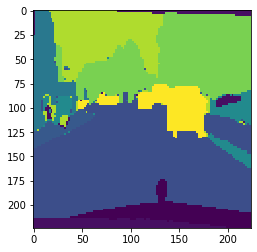

In [9]:
#Show predicated class for an image
#Class is chosen as the most likely class for each pixel
predictions = model_other.predict(train_x_resized[0:5])
flat_pred = (predictions.flatten())
predictions.shape
plt.imshow(np.array(tf.argmax(predictions[1,:,:,:],axis=-1)), interpolation='nearest')
np.shape(tf.argmax(predictions[:,:,:,:],axis=-1))

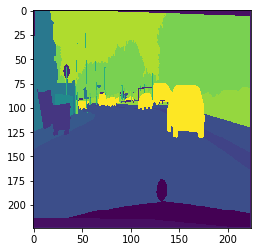

In [24]:
#Ground truth
plt.imshow(train_y_resized[1,:,:,0], interpolation='nearest')

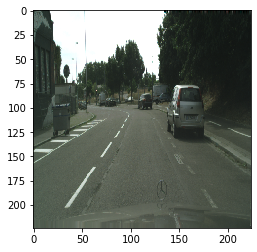

In [27]:
#Ground truth
plt.imshow(train_x_resized[1], interpolation='nearest')

In [44]:
#Test 
loss, acc = model_other.evaluate(test_x_resized,  test_y_resized, verbose=2)
acc

3/3 - 2s


0.6578083038330078

In [8]:
#Model saving
#Useful to checkpoint work.
model_other.save('saved_model/VGGwithPassthroughImageNetPreTrainedV7_10xV6toV7_120epochs') 

INFO:tensorflow:Assets written to: saved_model/VGGwithPassthroughImageNetPreTrainedV7_10xV6toV7_120epochs/assets


In [6]:
#Loading model.
model_other = tf.keras.models.load_model('saved_model/VGGwithPassthroughImageNetPreTrainedV7_10xV6toV7_120epochs')

Results:
The current in-sample accuracy was 0.8328, whereas out of sample accuracy is 0.6578. The model still shows steady progress when trained for longer. At initial training, the accuracy on in-sample examples below 0.0184, so there's a definite improvement.

Qualitatively, the model is doing what it is supposed to. By eye, the hand-annotated images in the training set is close to the generate map of labels from the model. 

#### Conclusions

I have a created a roughly working image segmentation neural network that is identify a range of objects in an urban environment. By presenting this information in a single documented notebook, I hope it is instructive in building image segmentation networks for Tensorflow 2.x using Keras. The model was trained over a few dozen hours on a Intel® Core™ i5-4670 CPU. 

#### Areas for improvement:
##### Computational:  
Increasing the number of training epochs would increase the accuracy. The model is showing steady improvement with successive iterations, so likely it will continue to improve in training accuracy. There is a significant difference in accuracy between the train and test examples. The neural net was run over only 32 images to speed training, so running over a higher number of samples from the Cityscapes data set would improve it.  
##### Algorithmic:  
There are a number of hyperparameters to optimized, as well as the network topography. The learning rate is a key one hyperparameter. I experimented in increasing it by 10x to 0.001 from 0.0001, and that did improve the speed of training. However, an additional 10x does not improve performance. Different activation functions such as Hard Swish can be tried. In addition, the order of layers can be adjusted. Different numbers of convultion filter, changing the depth of the network, and using different layers for passthrough would change the performance of the network. The decoder network is less deep than the VGG encoder network and has a somewhat different shape. Much of the established literature has symmetric encoder and decoder networks, so this topography is more experimental. 
##### Structural:  
There are a number of improvements that can be done with the code. Tensorflow training checkpoints could be used to more robustly create versioning for experiments. By rescaling the images to 224x224, some data is lost from the training set. The model can be trained with a validation training set in order to see the change of in-sample and out-of-sample error rates. The data could be loaded in more elegantly. 